In [1]:
import numpy as np
import matplotlib.pyplot as plt

from rot import ROT, EntropicROT
from rot import exact_rot
from rot import calc_f_rot, calc_logB, calc_B
from sinkhorn_rot import calc_U, calc_k_formula, robust_sinkhorn_eps
from utils import norm_inf

import time

In [2]:
# Dimension
n = 100

# Regularization
tau = np.float64(1.0)

In [3]:
np.random.seed(3698)

# Cost matrix
C = np.random.uniform(low=1.0, high=50.0, size=(n, n)).astype(np.float64)
C = (C + C.T) / 2.0

# Marginal vectors
a = np.random.uniform(0.1, 1.0, size=n).astype(np.float64)
b = np.random.uniform(0.1, 1.0, size=n).astype(np.float64)

a = a / a.sum()
b = b / b.sum()

In [4]:
# Original UOT problem
rot = ROT(C, a, b, tau)

# Optimal solution
f_optimal, X_optimal = exact_rot(rot)

print('Optimal:', f_optimal)

Optimal: 3.640274354955852


Epsilon 0: 1.0
0 9.13007059015058
1000 3.8289770540698886
1000 3.8289770540698886


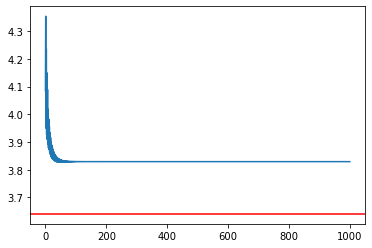

Time elapsed: 1.0951645374298096
Epsilon 1: 0.9236708571873862
0 9.13007059015058
1000 3.828977054069889
1000 3.828977054069889


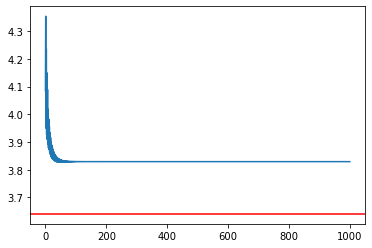

Time elapsed: 1.0485665798187256
Epsilon 2: 0.8531678524172809
0 9.13007059015058
1000 3.8289770540698886
1000 3.8289770540698886


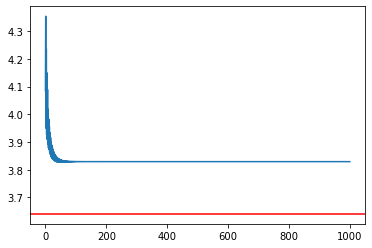

Time elapsed: 0.995490312576294
Epsilon 3: 0.7880462815669912
0 9.13007059015058
1000 3.8289770540698886
1000 3.8289770540698886


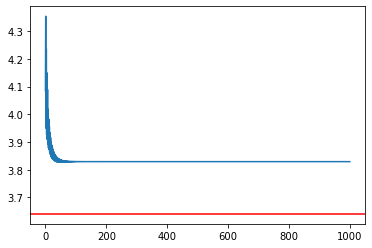

Time elapsed: 1.0160725116729736
Epsilon 4: 0.7278953843983151
0 9.13007059015058
1000 3.828977054069889
1000 3.828977054069889


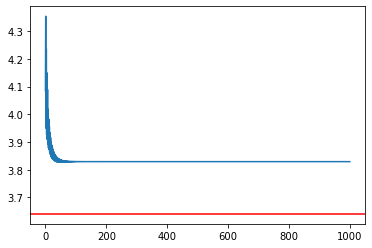

Time elapsed: 1.0037357807159424
Epsilon 5: 0.6723357536499337
0 9.13007059015058


KeyboardInterrupt: 

In [6]:
# Number of eps
neps = 30

# Epsilons
eps_arr = np.logspace(start=0, stop=-1, num=neps).astype(np.float64)

kfs, kcs = np.zeros((2, neps))

for i, eps in enumerate(eps_arr):
    print(f'Epsilon {i}:', eps)
    start = time.time()

    # Entropic regularization parameter
    U = calc_U(rot, eps)
    eta = eps / U

    # Convert to Entropic Regularized UOT
    erot = EntropicROT(C, a, b, tau, eta)

    # Sinkhorn
    _, log = robust_sinkhorn_eps(erot, f_optimal, eps, 
                                 patience=1000,
                                 save_uv=False, verbose=True)
    
    plt.plot(log['f'][1:])
    plt.axhline(f_optimal, color='red')
    plt.show()

    # Find k
    kfs[i] = calc_k_formula(erot, eps)
    kcs[i] = len(log['f']) - 1000

    print('Time elapsed:', time.time() - start)
    print('=================')

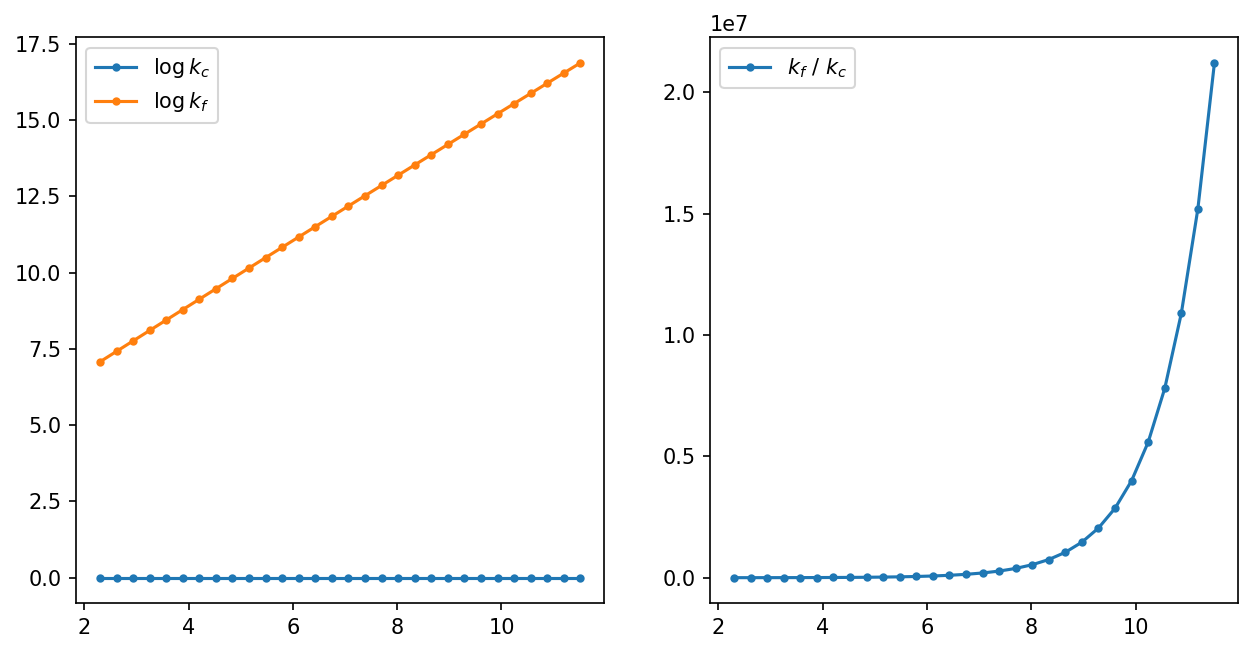

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=150)

ax[0].plot(np.log(1 / eps_arr), np.log(kcs), marker='.', label='$\log k_c$')
ax[0].plot(np.log(1 / eps_arr), np.log(kfs), marker='.', label='$\log k_f$')
ax[0].legend()

ax[1].plot(np.log(1 / eps_arr), kfs / kcs, marker='.', label='$k_f$ / $k_c$')
ax[1].legend()

In [8]:
# Original UOT problem
rsot = ROT(C, a, b, tau)

# Optimal solution
_, X_hat = exact_rot(rsot)

print('Optimal:', calc_f_rot(rsot, X_hat))

Optimal: 3.640274354955852


In [9]:
eps = 0.001

# Entropic regularization parameter
U = calc_U(rsot, eps)
eta = eps / U

# Convert to Entropic Regularized UOT
ersot = EntropicROT(C, a, b, tau, eta)

In [12]:
import cvxpy as cp
from rot import calc_g_rot

def exact_entreg_rot(p: EntropicROT, verbose: bool = False):
    n = p.C.shape[0]

    u = cp.Variable(shape=n)
    v = cp.Variable(shape=n)

    h = p.eta * cp.sum(cp.exp((u[:, None] + v[None, :] - p.C) / p.eta)) \
        + p.tau * cp.sum(cp.multiply(cp.exp(-u / p.tau), p.a)) \
        + p.tau * cp.sum(cp.multiply(cp.exp(-v / p.tau), p.b))
    obj = cp.Minimize(h)

    prob = cp.Problem(obj)
    prob.solve(verbose=verbose)

    return prob.value, u.value, v.value

_, u_star, v_star = exact_entreg_rot(ersot, verbose=False)
X_star = calc_B(ersot, u_star, v_star)
print('Optimal:', calc_f_rot(rsot, X_star), calc_g_rot(ersot, X_star))

Optimal: 1.6759934887683188 1.6758791763709944


/home/vltanh/miniconda3/envs/ot/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
